# Requirement 3
使用參數: n=3, sigma=0.01, pca(n_components)=20

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from collections import Counter
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# impoort 斷詞（要放 topwords_zh.txt 進資料夾）
with open('./stopwords_zh.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines() 
file.close()

In [3]:
df = pd.read_excel("stock_data_2019-2023.xlsx", sheet_name=["上市2020", "上市2021", "上市2022"], usecols=['證券代碼', '年月日', '收盤價(元)'])

In [4]:
# import stock excel
# 只留台積電的日期跟收盤價
# 按照日期由最早往最晚排
df_STOCK = pd.DataFrame()
for i in range(2020, 2023):
    df_STOCK = pd.concat([df_STOCK, df[(f"上市{i}")].loc[::-1]])

In [5]:
df_STOCK = df_STOCK[df_STOCK["證券代碼"] == "2330 台積電"].reset_index(drop = True)

In [6]:
# 更改年月日的日期格式
df_STOCK['年月日'] = pd.to_datetime(df_STOCK['年月日']).dt.date
df_STOCK.head(5)

,證券代碼,年月日,收盤價(元)
0,2330 台積電,2020-01-02,328.2957
1,2330 台積電,2020-01-03,328.7799
2,2330 台積電,2020-01-06,321.5168
3,2330 台積電,2020-01-07,319.0957
4,2330 台積電,2020-01-08,319.0957


In [7]:
# import news excel 
df_NEWS = pd.read_excel("TSMC_fly_news_20-22.xlsx")
df_NEWS.head()

,Unnamed: 0,post_time,title,content,token
0,0,2020-01-02,美股：美中協議月中簽署，四大指數週二齊漲約0.3%封關，費半全年狂升逾六成,美股週二開盤延續前一天拉回格局，主要指數以平低盤開出，，盤中美國總統川普發文宣稱1月15日會...,"['美股美中', '協議', '月中', '簽署', '四', '大', '指數', '週二..."
1,1,2020-01-02,《熱門族群》5G新機連發，帶旺璟德、聯發科,美國消費性電子展（CES）將於元月7日∼10日接續舉辦，法人預期5G仍將是本次展期焦點，加上...,"['熱門', '族群', '新機', '連', '發帶', '旺璟德', '聯發科', '熱..."
2,2,2020-01-02,《熱門族群》台積電走高，半導體設備股跟漲,台積電 (2330) 股價今早開高走高，帶領台積電供應鏈及半導體設備股再度轉強。隨著美中貿易...,"['熱門', '族群', '台積電', '走高', '半導體', '設備股', '跟', '..."
3,3,2020-01-02,台灣科技能打趴歐洲大廠？專家分析「還太早」,近年來台灣不論科技、經濟等發展，都大幅的成長，也逐漸讓國際看到台灣。不過在科技的成長方面，就...,"['台灣', '科技', '能', '打', '趴', '歐洲', '大廠', '專家', ..."
4,4,2020-01-02,京元電Q1營收估創同期高；全年看增雙位數,MoneyDJ新聞 2020-01-02 14:23:09 記者 王怡茹 報導<BR>京元電...,"['京元電', '營收', '估創', '同', '期', '高', '全', '年', '..."


In [8]:
# 更改年月日的日期格式
df_NEWS['post_time'] = pd.to_datetime(df_NEWS['post_time']).dt.date

In [9]:
df_NEWS['month_index'] = ""
for i in range(len(df_NEWS)):
    df_NEWS.loc[i, 'month_index'] = (df_NEWS.loc[i, 'post_time'].year-2020)*12 + df_NEWS.loc[i, 'post_time'].month - 1
df_NEWS.tail(5)

,Unnamed: 0,post_time,title,content,token,month_index
7455,7455,2022-12-28,道瓊聖誕假期後小漲37點，費半、那指各挫1.8%和1.4%，特斯拉再瀉11%,財訊快報道瓊聖誕假期後小漲37點，費半、那指各挫1.8%和1.4%，特斯拉再瀉11%閱讀全文...,"['道瓊', '聖誕', '假期', '後', '小漲', '點', '費半', '那', ...",35
7456,7456,2022-12-28,《美股掃瞄》債息急升打壓成長股 標普收黑、那指費半大跌(2-2),時報資訊《美股掃瞄》債息急升打壓成長股 標普收黑、那指費半大跌(2-2)閱讀全文 2022年...,"['美股', '掃瞄', '債息', '急升', '打壓', '成長股', '標普', '收...",35
7457,7457,2022-12-28,《半導體》宏觀今年營收拚增2成 明年毛利率向上,時報資訊《半導體》宏觀今年營收拚增2成 明年毛利率向上閱讀全文 2022年12月28日 上午...,"['半導體', '宏觀', '今年', '營收', '拚', '增成', '明年', '毛利...",35
7458,7458,2022-12-28,《半導體》聯發科毛利率跌破45% 外資曝時間點,時報資訊《半導體》聯發科毛利率跌破45% 外資曝時間點閱讀全文 2022年12月28日 上午...,"['半導體', '聯發科', '毛利率', '跌破', '外資', '曝', '時間點', ...",35
7459,7459,2022-12-28,擔憂市占及毛利率下滑，美系外資調降聯發科目標價至649元,財訊快報擔憂市占及毛利率下滑，美系外資調降聯發科目標價至649元閱讀全文 2022年12月2...,"['擔憂', '市占', '及', '毛利率', '下滑', '美系', '外資', '調降...",35


In [10]:
df_stock = df_STOCK.copy()
df_news = df_NEWS.copy()

In [11]:
# 如果調整這裡的參數，記得重新拿 df_stock（因為後面會 drop 持平）
day_n = 3 # 以 day_n 天後來看是漲還是跌
sigma = 0.01 # 以 sigma 決定漲（跌）幅超過幾 % 是漲（跌）


label = []
for i in range(len(df_stock) - day_n):
    rate = (df_stock['收盤價(元)'][i + day_n] - df_stock['收盤價(元)'][i]) / df_stock['收盤價(元)'][i]
    if rate > sigma:
       label.append('漲')
    elif rate < -sigma:
        label.append('跌')
    else:
        label.append('持平')
for i in range(day_n):
    label.append(0)
# label.extend([0, 0, 0])

df_stock['label'] = label
df_stock

,證券代碼,年月日,收盤價(元),label
0,2330 台積電,2020-01-02,328.2957,跌
1,2330 台積電,2020-01-03,328.7799,跌
2,2330 台積電,2020-01-06,321.5168,漲
3,2330 台積電,2020-01-07,319.0957,漲
4,2330 台積電,2020-01-08,319.0957,漲
...,...,...,...,...
730,2330 台積電,2022-12-26,454.0431,跌
731,2330 台積電,2022-12-27,454.5404,跌
732,2330 台積電,2022-12-28,448.5727,0
733,2330 台積電,2022-12-29,443.5996,0


In [12]:
upCnt = 0
downCnt = 0
flatCnt = 0
for i in range(len(df_stock)):
    if df_stock['label'][i] == '漲':
        upCnt += 1
    elif df_stock['label'][i] == '跌':
        downCnt += 1 
    else :
        flatCnt += 1
print(len(df_stock))
print('預估漲的天數：', upCnt)
print('預估跌的天數：', downCnt)
print('預估持平的天數：', flatCnt)

735
預估漲的天數： 261
預估跌的天數： 261
預估持平的天數： 213


In [13]:
# 丟掉持平的資料
df_stock = df_stock[df_stock.label != '持平']
df_stock = df_stock[df_stock.label != 0]
df_stock = df_stock.reset_index(drop = True)
# df_stock

In [14]:
from collections import defaultdict
dic=defaultdict(int)
for i in range(len(df_stock)):
    dic[(df_stock['年月日'][i])] = (df_stock['label'][i])

In [15]:
label_news = []
for i in range(len(df_news)):
    label_news.append(dic[df_news["post_time"][i]])
df_news['label'] = label_news
df_news.tail(10)

,Unnamed: 0,post_time,title,content,token,month_index,label
7450,7450,2022-12-27,宏觀明年毛利率有機會向上，持審慎樂觀看待,財訊快報宏觀明年毛利率有機會向上，持審慎樂觀看待閱讀全文 2022年12月27日 下午3:5...,"['宏觀', '明年', '毛利率', '有', '機會', '向', '上', '持', ...",35,跌
7451,7451,2022-12-27,駁斥台積電赴美投資是去台化 蔡總統：門兒都沒有,中央廣播電台駁斥台積電赴美投資是去台化 蔡總統：門兒都沒有閱讀全文 劉玉秋採訪2022年12...,"['駁斥', '台積電', '赴', '美', '投資', '是', '去', '台化', ...",35,跌
7452,7452,2022-12-28,蔡總統首度公開肯定：賴清德是最佳總統接班人選,工商時報蔡總統首度公開肯定：賴清德是最佳總統接班人選閱讀全文 彭媁琳／台北報導2022年12...,"['蔡', '總統', '首度', '公開', '肯定', '賴清德', '是', '最佳'...",35,0
7453,7453,2022-12-28,台積電股價沒有一家猜對！謝金河曝半導體變慘業：存在1危險性,中時財經即時台積電股價沒有一家猜對！謝金河曝半導體變慘業：存在1危險性閱讀全文 吳美觀202...,"['台積電', '股價', '沒有', '一', '家', '猜', '對', '謝金河',...",35,0
7454,7454,2022-12-28,《美股》公債殖利率攀高 那斯達克指數下跌1.38%,Moneydj理財網《美股》公債殖利率攀高 那斯達克指數下跌1.38%閱讀全文 2022年1...,"['美股', '公債', '殖利率', '攀高', '那斯達克', '指數', '下跌', ...",35,0
7455,7455,2022-12-28,道瓊聖誕假期後小漲37點，費半、那指各挫1.8%和1.4%，特斯拉再瀉11%,財訊快報道瓊聖誕假期後小漲37點，費半、那指各挫1.8%和1.4%，特斯拉再瀉11%閱讀全文...,"['道瓊', '聖誕', '假期', '後', '小漲', '點', '費半', '那', ...",35,0
7456,7456,2022-12-28,《美股掃瞄》債息急升打壓成長股 標普收黑、那指費半大跌(2-2),時報資訊《美股掃瞄》債息急升打壓成長股 標普收黑、那指費半大跌(2-2)閱讀全文 2022年...,"['美股', '掃瞄', '債息', '急升', '打壓', '成長股', '標普', '收...",35,0
7457,7457,2022-12-28,《半導體》宏觀今年營收拚增2成 明年毛利率向上,時報資訊《半導體》宏觀今年營收拚增2成 明年毛利率向上閱讀全文 2022年12月28日 上午...,"['半導體', '宏觀', '今年', '營收', '拚', '增成', '明年', '毛利...",35,0
7458,7458,2022-12-28,《半導體》聯發科毛利率跌破45% 外資曝時間點,時報資訊《半導體》聯發科毛利率跌破45% 外資曝時間點閱讀全文 2022年12月28日 上午...,"['半導體', '聯發科', '毛利率', '跌破', '外資', '曝', '時間點', ...",35,0
7459,7459,2022-12-28,擔憂市占及毛利率下滑，美系外資調降聯發科目標價至649元,財訊快報擔憂市占及毛利率下滑，美系外資調降聯發科目標價至649元閱讀全文 2022年12月2...,"['擔憂', '市占', '及', '毛利率', '下滑', '美系', '外資', '調降...",35,0


In [16]:
# 刪掉 label 是 0 的資料
df_news_no_zero = df_news[df_news.label != 0]
df_news_no_zero = df_news_no_zero.reset_index(drop = True)
#len(df_news_no_zero)

In [17]:
# token 型態轉換，fit in 套件
df_news_list = []
for i in range(len(df_news_no_zero)):
    df_news_list_tmp = []
    df_news_str = ''
    df_news_list_tmp = eval(df_news_no_zero.token[i])
    df_news_str = ' '.join(df_news_list_tmp)
    df_news_list.append(df_news_str)
len(df_news_list)

4863

In [18]:
df_news_no_zero['new_token'] = [news.split(' ') for news in df_news_list]

#### 標記33組3+1個月的資料於總資料集(df_news_no_zero)中的位置

In [19]:
month_index = []  ## [第一個月第一筆index, 第四個月第一筆資料index, 第四個月最後一筆資料index] 

## 資料集改了 記得改code中數字
for i in range(33):
    temp = []
    cnt = 0
    for j in range(len(df_news_no_zero)):
        if df_news_no_zero.month_index[j] == i and cnt==0:  ## 起頭月
            temp.append(j)
            cnt = 1
        #elif df_news_no_zero.post_time[j].month == (i%12) + 1 + 1:
            #cnt = 2
        #elif df_news_no_zero.post_time[j].month == (i%12) + 1 + 2:
            #cnt = 3
        elif df_news_no_zero.month_index[j] == i + 3 and cnt==1:
            cnt = 0
            temp.append(j)
        elif df_news_no_zero.month_index[j] == i + 4 and cnt==0 and i != 32:
            cnt = 5
            temp.append(j-1)
        elif df_news_no_zero.month_index[j] == 35 and j == len(df_news_no_zero) - 1 and len(month_index) == 32: #最後一筆資料
            temp.append(j)
            
    month_index.append(temp)
    
month_index

[[0, 167, 224],
 [125, 225, 300],
 [127, 301, 354],
 [167, 355, 516],
 [225, 517, 597],
 [301, 598, 730],
 [355, 731, 812],
 [517, 813, 882],
 [598, 883, 987],
 [731, 988, 1212],
 [813, 1213, 1286],
 [883, 1287, 1385],
 [988, 1386, 1534],
 [1213, 1535, 1664],
 [1287, 1665, 1759],
 [1386, 1760, 1862],
 [1535, 1863, 2003],
 [1665, 2004, 2148],
 [1760, 2149, 2230],
 [1863, 2231, 2354],
 [2004, 2355, 2471],
 [2149, 2472, 2604],
 [2231, 2605, 2718],
 [2355, 2719, 2874],
 [2472, 2875, 3021],
 [2605, 3022, 3181],
 [2719, 3182, 3345],
 [2875, 3346, 3566],
 [3022, 3567, 3841],
 [3182, 3842, 4026],
 [3346, 4027, 4353],
 [3567, 4354, 4734],
 [3842, 4735, 4862]]

### Requirement 1 and 2 重複33遍

In [20]:
def R1p1(new_df_news_no_zero):
    df_news_up = new_df_news_no_zero[new_df_news_no_zero['label'] == '漲'].reset_index(drop = True)
    df_news_down = new_df_news_no_zero[new_df_news_no_zero['label'] == '跌'].reset_index(drop = True)
    
    dict_stopwords = defaultdict(int)
    for word in stopwords:
        dict_stopwords[word] += 1
    
    tf_counter_up = Counter() # 預備統計tf用
    df_counter_up = Counter() # 預備統計df用

    upstr_list = []

    for i in range(len(df_news_up)):
        df_tmp_up=Counter() # 暫存本篇df用
        for term in df_news_up['new_token'][i]:
            if(dict_stopwords[term]):
                continue
            if(len(term) > 1): # 若詞長>1
                tf_counter_up[term] += 1 # tf加1
                upstr_list.append(term)
            if(df_tmp_up[term] == 0): # 若本篇之前不曾出現
                df_tmp_up[term] = 1 # df標為1
        df_counter_up += df_tmp_up # 累加多篇df
    tfidf_up = Counter()
    for i in range(len(upstr_list)):
        item  = upstr_list[i]
        pts = (1 + math.log(tf_counter_up[item]) * math.log(len(df_news_no_zero)/df_counter_up[item]))
        tfidf_up[item] = pts
    
    tf_counter_down = Counter() #預備統計tf用
    df_counter_down = Counter() #預備統計df用

    downstr_list = []

    for i in range(len(df_news_down)):
        df_tmp_down=Counter() #暫存本篇df用
        for term in df_news_down['new_token'][i]:
            if(dict_stopwords[term]):
                continue
            if(len(term) > 1): #若詞長>1
                tf_counter_down[term] += 1 #tf加1
                downstr_list.append(term)
            if(df_tmp_down[term] == 0): #若本篇之前不曾出現
                df_tmp_down[term] = 1 #df標為1
        df_counter_down += df_tmp_down # 累加多篇df
    tfidf_down = Counter()
    for i in range(len(downstr_list)):
        item  = downstr_list[i]
        pts = (1 + math.log(tf_counter_down[item]) * math.log(len(df_news_no_zero)/df_counter_down[item]))
        tfidf_down[item] = pts
        
    allstr_list = upstr_list + downstr_list
    tf_counter_all = Counter()
    df_counter_all = Counter()
    for item in allstr_list:
        tf_counter_all[item] = tf_counter_up[item] + tf_counter_down[item]
        df_counter_all[item] = df_counter_up[item] + df_counter_down[item]
        
    #tfidf_chi_up
    chi_tfidf_up = Counter()
    for item in upstr_list:
        expected_tf = tf_counter_all[item] / (len(df_news_up.index) + len(df_news_down.index)) * len(df_news_up)
        expected_df = df_counter_all[item] / (len(df_news_up.index) + len(df_news_down.index)) * len(df_news_up)
    
        if tf_counter_up[item] < expected_tf:
            n1 = -1
        else:
            n1 = 1
        tf_pts = (tf_counter_all[item] - expected_tf)**2 / expected_tf
        if df_counter_up[item] < expected_df:
            n2 = -1
        else:
            n2 = 1
        df_pts = (df_counter_all[item] - expected_df)**2 / expected_df
        chi_pts = tfidf_up[item] * math.sqrt(tf_pts) * math.sqrt(df_pts) * n1 * n2
        chi_tfidf_up[item] = chi_pts
        
    #tfidf_chi_down
    chi_tfidf_down = Counter()
    for item in downstr_list:
        expected_tf = tf_counter_all[item] / (len(df_news_up.index) + len(df_news_down.index)) * len(df_news_down)
        expected_df = df_counter_all[item] / (len(df_news_up.index) + len(df_news_down.index)) * len(df_news_down)

        if tf_counter_down[item] < expected_tf:
            n1 = -1
        else:
            n1 = 1
        tf_pts = (tf_counter_all[item] - expected_tf)**2 / expected_tf
        if df_counter_down[item] < expected_df:
            n2 = -1
        else:
            n2 = 1
        df_pts = (df_counter_all[item] - expected_df)**2 / expected_df
        chi_pts = tfidf_down[item] * math.sqrt(tf_pts) * math.sqrt(df_pts) * n1 * n2
        chi_tfidf_down[item] = chi_pts
        
        return chi_tfidf_up, chi_tfidf_down

In [21]:
def R1p2(new_df_news_no_zero, new_df_news_list, chi_tfidf_up, chi_tfidf_down, one_month_index):
    # 取前 n 名關鍵字的差集
    # n -> most_common(n)
    list_up = [word[0] for word in chi_tfidf_up.most_common(12000)]
    list_down = [word[0] for word in chi_tfidf_down.most_common(12000)]

    key_diff = list(set(list_up).difference(set(list_down)))
    
    X_data = new_df_news_list
    Y_data = new_df_news_no_zero['label']
    
    return X_data, Y_data, key_diff

In [22]:
def R1p3(X_data, key_diff):
    # 將所有資料向量化，轉成 tfidf vector
    vectorizer = TfidfVectorizer(stop_words=stopwords)
    TFIDF_vectors = vectorizer.fit_transform(X_data)
    TFIDF_vectors = pd.DataFrame(TFIDF_vectors.toarray(), columns = vectorizer.get_feature_names_out())
    
    diff_vectors = TFIDF_vectors[key_diff]
    return diff_vectors

In [23]:
def R1p4(diff_vectors, Y_data):
    X_train, X_test, Y_train, Y_test = train_test_split(diff_vectors, Y_data, test_size = 0.2, random_state = 2, stratify = Y_data)
    #PCA
    pca_model = PCA(n_components = 20) # 取多少重要關鍵字調：n_components
    pca_model.fit(X_train, Y_train)
    X_train = pca_model.transform(X_train)
    X_test = pca_model.transform(X_test)
    return X_train, X_test, Y_train, Y_test

In [24]:
def R2(X_train, X_test, Y_train, Y_test):
    result = []

    from sklearn import metrics
    # Gradient Boosting Classifier
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7, random_state=1, max_features='sqrt')
    clf.fit(X_train, Y_train)
    GBC_predicted_y = clf.predict(X_test)
    #print('GBC Accuracy:', metrics.accuracy_score(Y_test, GBC_predicted_y))
    result.append(GBC_predicted_y)
    
    # NB
    from sklearn.naive_bayes import BernoulliNB
    NB_model = BernoulliNB()
    NB_model.fit(X_train,Y_train)
    NB_predicted_y = NB_model.predict(X_test)
    #print('NB Accuracy:', metrics.accuracy_score(Y_test, NB_predicted_y))
    result.append(NB_predicted_y)


    # SVM
    from sklearn.svm import SVC
    SVM_model = SVC(kernel = 'rbf', C = 100.0, gamma = 1, probability=True)
    SVM_model.fit(X_train,Y_train)
    SVM_predicted_y = SVM_model.predict(X_test)
    #print('SVM Accuracy:', metrics.accuracy_score(Y_test, SVM_predicted_y))
    result.append(SVM_predicted_y)


    # DT
    from sklearn.tree import DecisionTreeClassifier                          
    classifier = DecisionTreeClassifier(criterion = "entropy")
    classifier.fit(X_train, Y_train)
    DT_predicted_y = classifier.predict(X_test)
    #print("DT Accuracy:", metrics.accuracy_score(Y_test, DT_predicted_y)) # 比對答案，計算準確率
    result.append(DT_predicted_y)


    # RF
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 100, max_features="sqrt")
    forest_fit = forest.fit(X_train, Y_train)
    RM_predicted_y = forest.predict(X_test)
    #print("RM Accuracy:", metrics.accuracy_score(Y_test, RM_predicted_y))
    result.append(RM_predicted_y)

    # KNN
    # from sklearn.neighbors import KNeighborsClassifier
    # classifie = KNeighborsClassifier(n_neighbors = 7)
    # classifie.fit(X_train, Y_train)
    # KNN_predicted_y = classifie.predict(X_test)
    # print("KNN Accuracy:", metrics.accuracy_score(Y_test, KNN_predicted_y)) # 比對答案，計算準確率
    # result.append(KNN_predicted_y)

    # voting
    res = pd.DataFrame(result, index=["GBC", "NB", "SVM", "DT", "RF"])
    pred = [(max(list(res[i]), key=list(res[i]).count)) for i in range(len(res.columns))]
    #print("Accuracy after voting:", metrics.accuracy_score(Y_test, pred)) # 比對答案，計算準確率
    return clf, NB_model, SVM_model, classifier, forest

In [25]:
def R2_1(clf, NB_model, SVM_model, classifier, forestt, X_test, Y_test):
    result = []

    from sklearn import metrics
    # Gradient Boosting Classifier
    from sklearn.ensemble import GradientBoostingClassifier
    #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7, random_state=1, max_features='sqrt')
    #clf.fit(X_train, Y_train)
    GBC_predicted_y = clf.predict(X_test)
    #print('GBC Accuracy:', metrics.accuracy_score(Y_test, GBC_predicted_y))
    result.append(GBC_predicted_y)
    
    # NB
    from sklearn.naive_bayes import BernoulliNB
    #NB_model = BernoulliNB()
    #NB_model.fit(X_train,Y_train)
    NB_predicted_y = NB_model.predict(X_test)
    #print('NB Accuracy:', metrics.accuracy_score(Y_test, NB_predicted_y))
    result.append(NB_predicted_y)


    # SVM
    from sklearn.svm import SVC
    #SVM_model = SVC(kernel = 'rbf', C = 100.0, gamma = 1, probability=True)
    #SVM_model.fit(X_train,Y_train)
    SVM_predicted_y = SVM_model.predict(X_test)
    #print('SVM Accuracy:', metrics.accuracy_score(Y_test, SVM_predicted_y))
    result.append(SVM_predicted_y)


    # DT
    from sklearn.tree import DecisionTreeClassifier                          
    #classifier = DecisionTreeClassifier(criterion = "entropy")
    #classifier.fit(X_train, Y_train)
    DT_predicted_y = classifier.predict(X_test)
    #print("DT Accuracy:", metrics.accuracy_score(Y_test, DT_predicted_y)) # 比對答案，計算準確率
    result.append(DT_predicted_y)


    # RF
    from sklearn.ensemble import RandomForestClassifier
    #forest = RandomForestClassifier(n_estimators = 100, max_features="sqrt")
    #forest_fit = forest.fit(X_train, Y_train)
    RM_predicted_y = forest.predict(X_test)
    #print("RM Accuracy:", metrics.accuracy_score(Y_test, RM_predicted_y))
    result.append(RM_predicted_y)

    # KNN
    # from sklearn.neighbors import KNeighborsClassifier
    # classifie = KNeighborsClassifier(n_neighbors = 7)
    # classifie.fit(X_train, Y_train)
    # KNN_predicted_y = classifie.predict(X_test)
    # print("KNN Accuracy:", metrics.accuracy_score(Y_test, KNN_predicted_y)) # 比對答案，計算準確率
    # result.append(KNN_predicted_y)

    # voting
    res = pd.DataFrame(result, index=["GBC", "NB", "SVM", "DT", "RF"])
    pred = [(max(list(res[i]), key=list(res[i]).count)) for i in range(len(res.columns))]
    #print("Accuracy after voting:", metrics.accuracy_score(Y_test, pred)) # 比對答案，計算準確率
    
    return pred, Y_test

In [26]:
def calculation(match_df):
    unique_date = match_df.date.values.tolist()
    unique_date = list(dict.fromkeys(unique_date))
    date_group = match_df.groupby('date')
    all_occur_up = []
    all_occur_down = []
    all_actual = []
    
    for i in unique_date:
        samedate_df = date_group.get_group(i)
        occur_up=0
        occur_down=0
        actual = samedate_df.iloc[0]['expectation']
        for j in samedate_df['prediction']:
            if j == '漲':
                occur_up+=1
            elif j == '跌':
                occur_down+=1
        all_occur_up.append(occur_up)
        all_occur_down.append(occur_down)
        all_actual.append(actual)
        
    occurrences = pd.DataFrame({'date':unique_date, '漲':all_occur_up, '跌':all_occur_down, '真實': all_actual})
    return occurrences

In [27]:
# 出手率及準確率
def hand(occur):
    occur['出手'] = ''
    hand_cnt = 0
    accu = 0
    for i in range(len(occur)):
        if occur['漲'][i]==occur['跌'][i]:
            occur['出手'][i] = 'no'
        elif occur['漲'][i]>occur['跌'][i]:
            if occur['漲'][i]-occur['跌'][i]>occur['漲'][i]*(1/3):
                occur['出手'][i] = '漲'
                hand_cnt += 1
                if occur['真實'][i] == '漲':
                    accu += 1
            else:
                occur['出手'][i] = 'no'
        elif occur['漲'][i]<occur['跌'][i]:
            if occur['跌'][i]-occur['漲'][i]>occur['跌'][i]*(1/3):
                occur['出手'][i] = '跌'
                hand_cnt += 1
                if occur['真實'][i] == '跌':
                    accu += 1
            else:
                occur['出手'][i] = 'no'
                
    hand_rate = hand_cnt/len(occur)
    accuracy = accu/hand_cnt
    return hand_cnt, hand_rate, accuracy

In [28]:
full_predicted = []
full_expected = []
full_date = []

chart_date = []
chart_hand_cnt = []
chart_hand_rate = []
chart_accuracy = []
for i in range(33):
    new_df_news_no_zero = df_news_no_zero[month_index[i][0]:month_index[i][1]]
    new_df_news_list = df_news_list[month_index[i][0]:month_index[i][1]]
    one_month_index = month_index[i]
    
    chi_tfidf_up, chi_tfidf_down = R1p1(new_df_news_no_zero)
    X_data, Y_data, key_diff = R1p2(new_df_news_no_zero, new_df_news_list, chi_tfidf_up, chi_tfidf_down, one_month_index)
    diff_vectors = R1p3(X_data, key_diff)
    X_train, X_test, Y_train, Y_test = R1p4(diff_vectors, Y_data)
    
    clf, NB_model, SVM_model, classifier, forest = R2(X_train, X_test, Y_train, Y_test)
    
    # month 4 prediction
    month_4_news_no_zero = df_news_no_zero[month_index[i][1]:month_index[i][2]+1]
    month_4_news_list = df_news_list[month_index[i][1]:month_index[i][2]+1]
    date = df_news_no_zero.post_time[month_index[i][1]:month_index[i][2]+1]
    date_string = []
    for j in date:
        date_string.append('{}/{}/{}'.format(j.year, j.month, j.day))
    
    chi_tfidf_up_4, chi_tfidf_down_4 = R1p1(month_4_news_no_zero)
    X_data_4, Y_data_4, key_diff_4 = R1p2(month_4_news_no_zero, month_4_news_list, chi_tfidf_up_4, chi_tfidf_down_4, one_month_index)
    diff_vectors_4 = R1p3(X_data_4, key_diff_4)
    
    pca_model_4 = PCA(n_components = 20) # 取多少重要關鍵字調：n_components
    pca_model_4.fit(diff_vectors_4, Y_data_4)
    X_data_4 = pca_model_4.transform(diff_vectors_4)
    
    predicted, expected = R2_1(clf, NB_model, SVM_model, classifier, forest, X_data_4, Y_data_4)
    match_df = pd.DataFrame({'date': date_string, 'prediction': predicted, 'expectation': expected})
    occur = calculation(match_df) #每天漲與跌篇數的dataframe
    #print("Occurrences: \n", occur)
    hand_cnt, hand_rate, accuracy = hand(occur)
    if (i%12)+4 > 12:
        month = (i%12)+4 - 12
    else:
        month = (i%12)+4
    #print('{}/{} 預測結果: '.format(int((i+3)/12)+2020, month), ', 出手次數: ', hand_cnt, ', 出手率: ', hand_rate, ", 準確率: ", accuracy)
    chart_date.append('{}/{}'.format(int((i+3)/12)+2020, month))
    chart_hand_cnt.append(hand_cnt)
    chart_hand_rate.append(hand_rate)
    chart_accuracy.append(accuracy)
    
    full_predicted.extend(predicted)
    full_expected.extend(expected)
    full_date.extend(date_string)

## 各預測月出手次數、出手率及準確率
出手與否判斷準則: 「漲」與「跌」篇數較多者需佔總篇數超過60%

In [29]:
monthly = pd.DataFrame({'月份':chart_date, '出手次數': chart_hand_cnt, '出手率': chart_hand_rate, '準確率': chart_accuracy})
monthly

,月份,出手次數,出手率,準確率
0,2020/4,11,0.687500,0.909091
1,2020/5,8,0.888889,0.875000
2,2020/6,8,0.800000,0.875000
3,2020/7,15,0.833333,0.933333
4,2020/8,14,1.000000,0.571429
5,2020/9,18,1.000000,0.555556
6,2020/10,11,0.916667,0.454545
7,2020/11,10,0.833333,1.000000
8,2020/12,12,0.800000,0.666667
9,2021/1,12,0.666667,0.833333


## 總出手率及總準確率(及confusion matrix)

In [30]:
match_df_2 = pd.DataFrame({'date': full_date, 'prediction': full_predicted, 'expectation': full_expected})
occur_2 = calculation(match_df_2)
hand_cnt_2, hand_rate_2, accuracy_2 = hand(occur_2)
print("總出手率: ", hand_rate_2, ", 總準確率: ", accuracy_2)

# confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(full_expected, full_predicted, labels = ['漲', '跌'])) # 印出混淆矩陣
# expected/predicted 看漲   看跌
#    看漲         TN     FP
#    看跌         FN     TP

總出手率:  0.7801268498942917 , 總準確率:  0.7100271002710027
[[1443  868]
 [1009 1376]]


In [31]:
avg_accuracy = []
for i in range(len(chart_date)):
    avg_accuracy.append(0.7063711911357341)

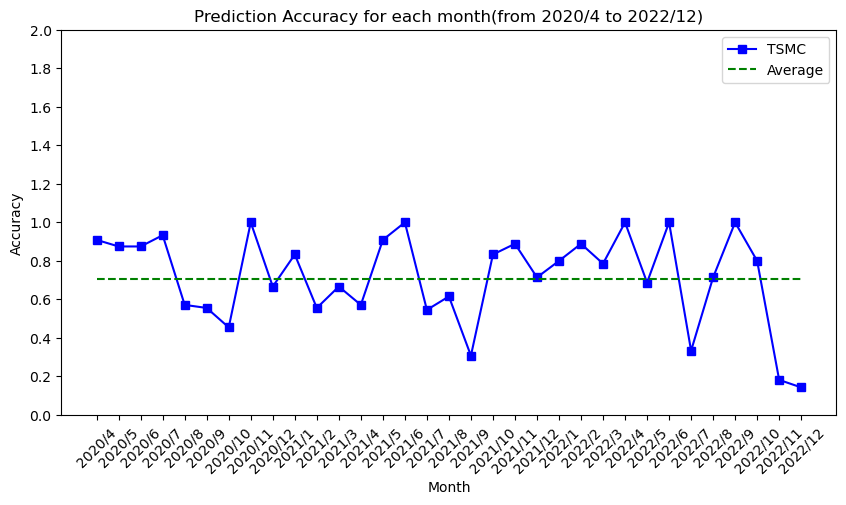

In [32]:
# import matplotlib相關套件

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5),dpi=100,linewidth = 2)
plt.plot(chart_date,chart_accuracy,'s-',color = 'b', label="TSMC")
plt.plot(chart_date,avg_accuracy,'--',color = 'g', label="avg")
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel('Accuracy')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
plt.legend(['TSMC', 'Average'])
plt.title("Prediction Accuracy for each month(from 2020/4 to 2022/12)")

plt.show()